In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import numpy as np

In [278]:
column_names = ['label', 'x', 'y', 'filename', 'img_width', 'img_height']
df = pd.read_csv("annotated_data/crowd-counting.csv", header=None, names=column_names)

current_annotations = df[df['filename'] == "1660719600.jpg"]

display(current_annotations.head())

,label,x,y,filename,img_width,img_height
0,person,748,538,1660719600.jpg,1920,1080
1,person,723,541,1660719600.jpg,1920,1080
2,person,180,552,1660719600.jpg,1920,1080
3,person,485,550,1660719600.jpg,1920,1080
4,person,541,540,1660719600.jpg,1920,1080


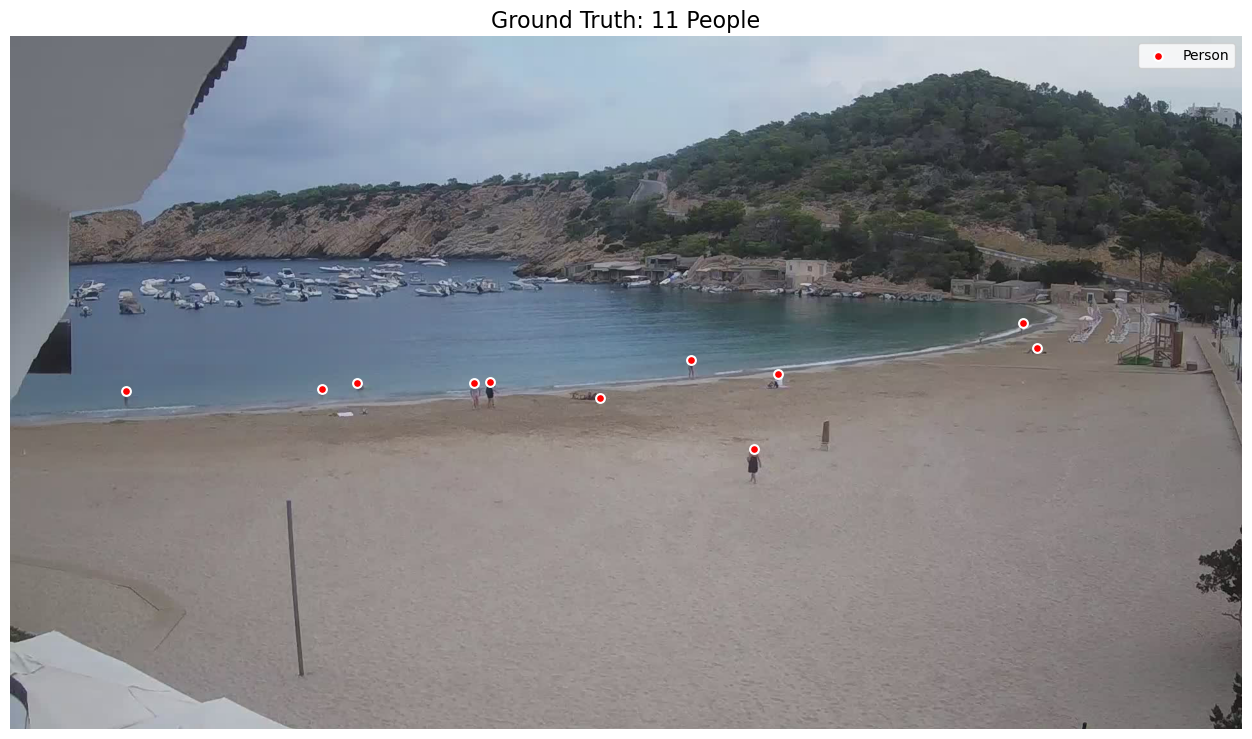

In [279]:
plt.figure(figsize=(16, 9))

img = mpimg.imread("data/1660719600.jpg")
plt.imshow(img)

plt.scatter(
    current_annotations['x'],
    current_annotations['y'],
    c='red',
    s=40,
    marker='o',
    edgecolors='white',
    linewidths=1.5,
    label='Person'
)

plt.title(f"Ground Truth: {len(current_annotations)} People", fontsize=16)
plt.axis('off')
plt.legend()
plt.show()

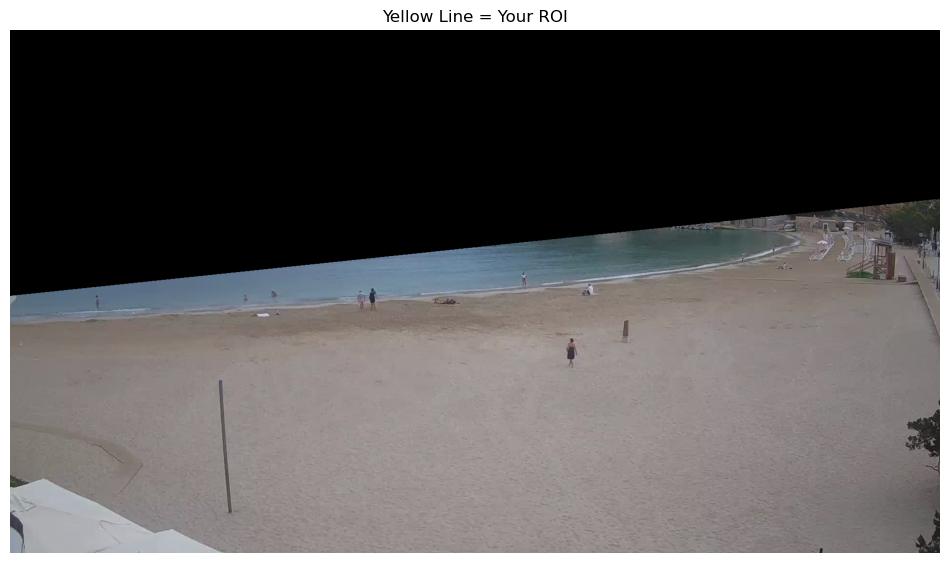

In [280]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Images ---
img_bg = cv2.imread("data/1660712400.jpg")
img_target = cv2.imread("data/1660719600.jpg")
# img_rgb is NOT needed for calculation, only for display.
# We will do math in BGR to match OpenCV defaults.

# --- 2. Create ROI Mask ---
roi_points = np.array([
    [0, 550],
    [1920, 350],
    [1920, 1080],
    [0, 1080]
], dtype=np.int32)

# FIX: Create a 1-Channel Mask (Greyscale) specifically for logic
# This prevents the dimension mismatch error later.
mask_roi_1ch = np.zeros(img_target.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask_roi_1ch, [roi_points], 255)

# Apply Mask to Color Images
# We use the 1-channel mask to filter the 3-channel image
img_bg = cv2.bitwise_and(img_bg, img_bg, mask=mask_roi_1ch)
img_target = cv2.bitwise_and(img_target, img_target, mask=mask_roi_1ch)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))
plt.title("Yellow Line = Your ROI")
plt.axis('off')
plt.show()

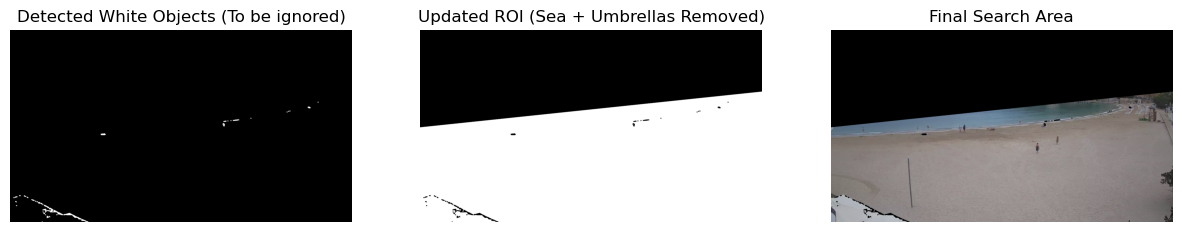

In [281]:
# --- Configuration ---
# Define what "White" means in BGR.
# Higher numbers = stricter (must be very bright).
# Try 200, 210, or 220 depending on how bright the sand is.
white_threshold = 190

lower_white = np.array([white_threshold, white_threshold, white_threshold])
upper_white = np.array([255, 255, 255])

# 1. Find White Pixels
# Returns a mask where White Objects = 255, Everything else = 0
umbrella_mask = cv2.inRange(img_target, lower_white, upper_white)

# 2. Expand the mask slightly (Optional)
# This ensures we cover the edges of the umbrella, not just the bright center
kernel_umbrella = np.ones((5, 5), np.uint8)
umbrella_mask = cv2.dilate(umbrella_mask, kernel_umbrella, iterations=1)

# 3. Update the Main ROI Mask
# We want to Keep the ROI (White) BUT Remove the Umbrellas (Make them Black)
# Logic: New_Mask = Old_Mask AND (NOT Umbrella_Mask)
mask_roi_1ch = cv2.bitwise_and(mask_roi_1ch, cv2.bitwise_not(umbrella_mask))

# --- Visualization ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(umbrella_mask, cmap='gray')
plt.title("Detected White Objects (To be ignored)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_roi_1ch, cmap='gray')
plt.title("Updated ROI (Sea + Umbrellas Removed)")
plt.axis('off')

plt.subplot(1, 3, 3)
# Show the image with the new mask applied
masked_img = cv2.bitwise_and(img_target, img_target, mask=mask_roi_1ch)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Final Search Area")
plt.axis('off')

plt.show()

Dynamic Sand Color (BGR): [135. 134. 142.]


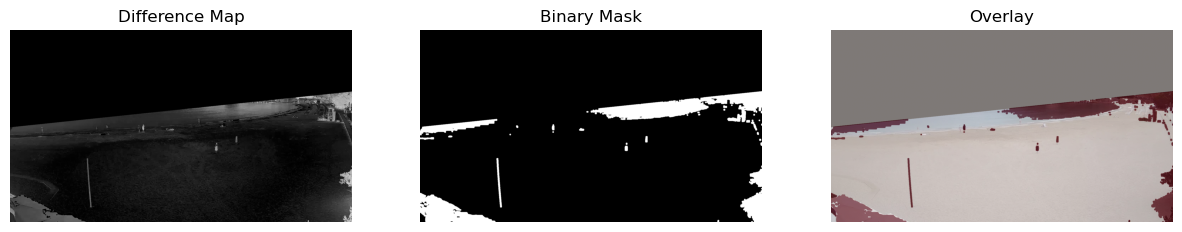

In [282]:
# --- 3. Dynamic Color Calculation ---
# Extract pixels using the 1-channel mask.
# img_target is (H, W, 3), mask is (H, W). Result is (N_pixels, 3).
sand_pixels = img_target[mask_roi_1ch > 0]

# Calculate MEDIAN (in BGR because img_target is BGR)
dominant_color = np.median(sand_pixels, axis=0)
print(f"Dynamic Sand Color (BGR): {dominant_color}")

# --- 4. Euclidean Color Distance ---
# FIX: Use img_target (BGR) so it matches dominant_color (BGR).
# If you subtract RGB - BGR, the math will be wrong.
diff = np.linalg.norm(img_target - dominant_color, axis=2)

# Convert to uint8
diff = diff.astype(np.uint8)

# FIX: Use the 1-channel mask here to fix the crash
diff = cv2.bitwise_and(diff, diff, mask=mask_roi_1ch)

# --- 5. Thresholding ---
# Pixels "far" from sand color are people
_, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

# --- 6. Morphological Cleaning ---
kernel = np.ones((3, 3), np.uint8)

# 1. Opening: Erode -> Dilate
# We increase iterations to 2 to scrub harder
clean_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 2. Median Blur (New Addition)
# The '5' is the kernel size. It wipes out isolated dots efficiently.
clean_mask = cv2.medianBlur(clean_mask, 5)

# 3. Dilation
# Grow the remaining people back to their original size
clean_mask = cv2.dilate(clean_mask, kernel, iterations=2)

# --- Visualization ---
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(diff, cmap='gray')
plt.title("Difference Map")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(clean_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
# Convert BGR to RGB just for final display
plt.imshow(cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB))
plt.imshow(clean_mask, alpha=0.5, cmap='Reds')
plt.title("Overlay")
plt.axis('off')

plt.show()

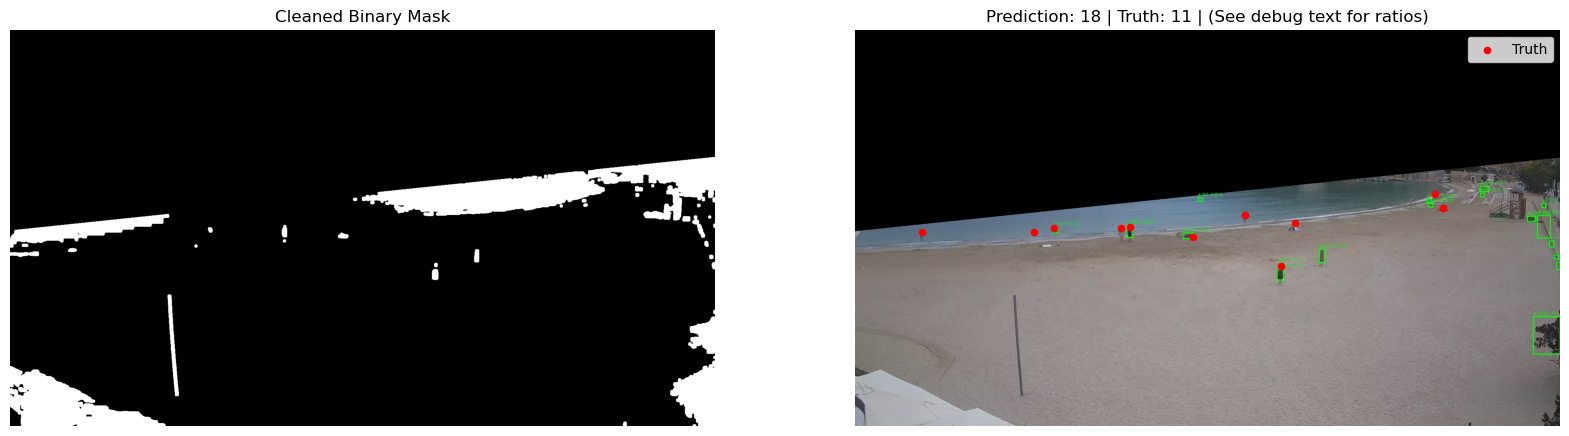

In [283]:


# 2. Find Contours
contours, hierarchy = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Filter and Draw
img_result = img_target.copy()
estimated_count = 0
SHOW_DEBUG_TEXT = True

for cnt in contours:
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    y_center = y + h // 2

    # --- DYNAMIC AREA THRESHOLDS ---
    # (Same as before)
    min_area_dynamic = 20 + (y_center / 1080) * 100
    max_area_dynamic = 800 + (y_center / 1080) * 5200

    if min_area_dynamic < area < max_area_dynamic:

        # Calculate Aspect Ratio (Height / Width)
        aspect_ratio = float(h) / w

        # --- ASPECT RATIO FILTER (The Fix) ---
        # > 0.5 rejects flat things (lying down people/waves)
        # < 5.0 rejects extremely tall/thin things (poles/sticks)
        # Tweak "5.0" based on the debug text if the stick is still detected.
        if 0.5 < aspect_ratio < 5.0:

            estimated_count += 1

            # Draw Green Box
            cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Draw Debug Text (Area and Ratio)
            if SHOW_DEBUG_TEXT:
                # Format: "A:120 R:2.1"
                debug_str = f"A:{int(area)} R:{aspect_ratio:.1f}"
                cv2.putText(img_result, debug_str, (x, y - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

# --- Visualization ---
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(clean_mask, cmap='gray')
plt.title("Cleaned Binary Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.scatter(current_annotations['x'], current_annotations['y'], c='red', s=20, label='Truth')
plt.title(f"Prediction: {estimated_count} | Truth: {len(current_annotations)} | (See debug text for ratios)")
plt.axis('off')
plt.legend()

plt.show()